In [1]:
import sys
import os
import datetime

sys.path.insert(0, '/mnt/data/molchanov/dltranz')

import torch
import torch.nn.functional as F
from torch.autograd import Function, Variable
import numpy as np
import random

import matplotlib.pyplot as plt

from uplift.models import *
from uplift.data import *
from uplift.constants import *
from uplift.utils import *
from uplift.losses import *
from torch.utils.tensorboard import SummaryWriter

def draw(imgs):
        if isinstance(imgs, list):
            imgs = torch.stack(imgs)
        fig = plt.figure()
        rows, columns = 1, imgs.shape[0]
        for i in range(imgs.shape[0]):
            fig.add_subplot(rows, columns, i+1)
            if imgs[i].size(0) == 3:
                plt.imshow(imgs[i].transpose(0, 1).transpose(1, 2))
            else:
                plt.imshow(imgs[i])
        plt.show()
        
def draw_rgb(imgs):
    if isinstance(imgs, list):
        imgs = torch.stack(imgs)
    fig = plt.figure()
    rows, columns = 1, imgs.shape[0]
    for i in range(imgs.shape[0]):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(imgs[i].transpose(0, 1).transpose(1, 2))
    plt.show()
        
%matplotlib inline


model _params:
        CURRENT_PARAMS cifar10_metric_learning
        N_AUGMENTS 5
        LEARNING_RATE 0.002
        GAMMA 0.9025
        BATCH_SIZE 128
        EPOCHS 150
        SAMPLING_STRATEGY HardNegativePair
        NEGATIVES_COUNT 5
        MARGING 0.5
        STEP_SIZE 5
        MODEL_POSTFIX cifar10_pos_contrastive_loss_percentile_sum
        ADD_INFO {'losses': [{'name': 'PositiveContrastiveLoss', 'marging': 0.5, 'neg_count': 5, 'sampling_strategy': 'HardNegativePair'}]}
        ERROR_RATE 0.5
       


# UNET

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels // 2, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64 * factor, bilinear)
        self.bn = nn.BatchNorm2d(64),
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        #x = self.bn(x)
        logits = self.outc(x)
        return logits

Files already downloaded and verified


  3%|▎         | 20/782 [00:08<04:58,  2.56it/s, loss=0.0882, ep=0]

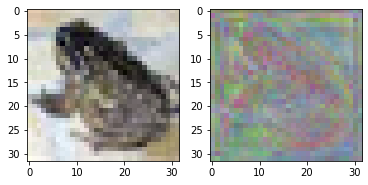

  5%|▌         | 40/782 [00:16<04:57,  2.49it/s, loss=0.0854, ep=0]

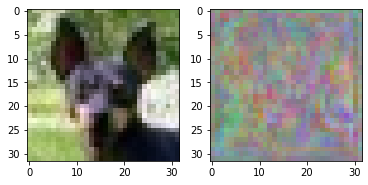

  8%|▊         | 60/782 [00:24<04:45,  2.53it/s, loss=0.0982, ep=0]

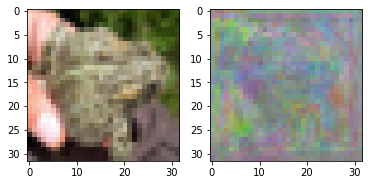

 10%|█         | 80/782 [00:32<04:28,  2.61it/s, loss=0.0866, ep=0]

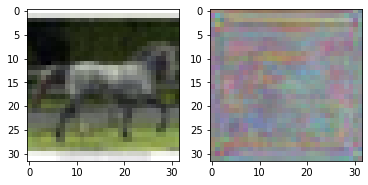

 13%|█▎        | 100/782 [00:40<04:31,  2.52it/s, loss=0.0943, ep=0]

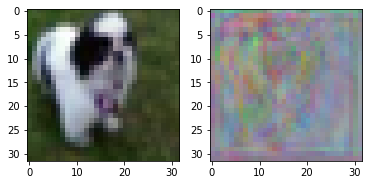

 15%|█▌        | 120/782 [00:48<04:31,  2.44it/s, loss=0.0864, ep=0]

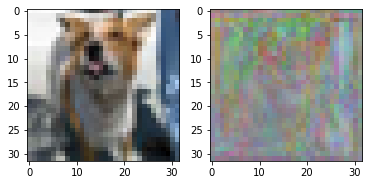

 18%|█▊        | 140/782 [00:57<04:11,  2.55it/s, loss=0.0899, ep=0]

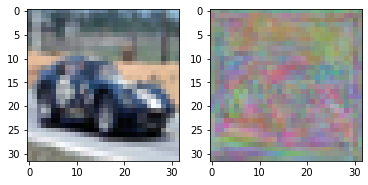

 20%|██        | 160/782 [01:05<04:22,  2.37it/s, loss=0.0924, ep=0]

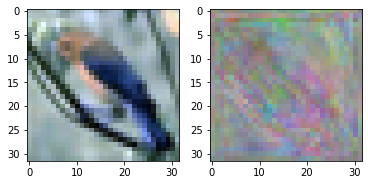

 23%|██▎       | 180/782 [01:12<02:55,  3.43it/s, loss=0.0957, ep=0]

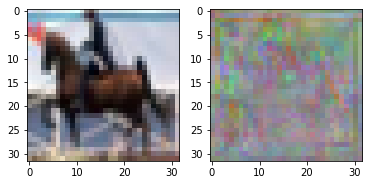

 26%|██▌       | 200/782 [01:16<01:25,  6.77it/s, loss=0.0813, ep=0]

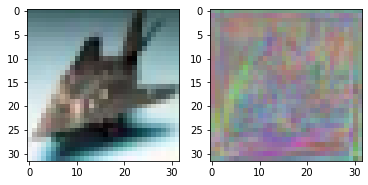

 28%|██▊       | 220/782 [01:22<04:05,  2.29it/s, loss=0.0908, ep=0]

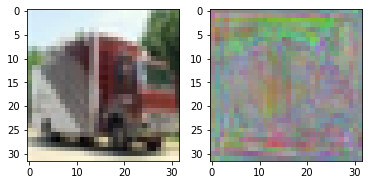

 31%|███       | 240/782 [01:31<03:26,  2.63it/s, loss=0.0891, ep=0]

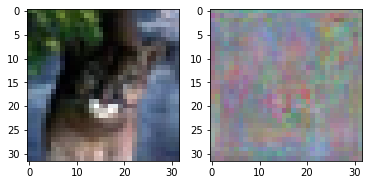

 33%|███▎      | 260/782 [01:39<03:29,  2.49it/s, loss=0.0888, ep=0]

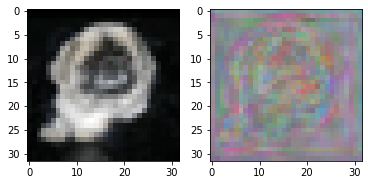

 36%|███▌      | 280/782 [01:47<03:16,  2.56it/s, loss=0.0871, ep=0]

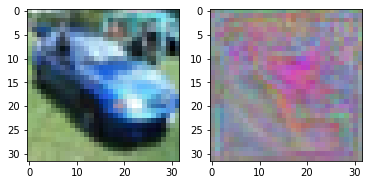

 38%|███▊      | 300/782 [01:55<03:19,  2.42it/s, loss=0.096, ep=0] 

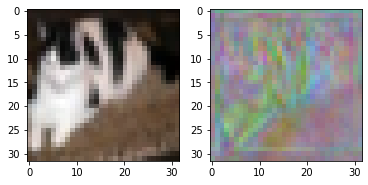

 41%|████      | 320/782 [02:03<03:12,  2.40it/s, loss=0.0869, ep=0]

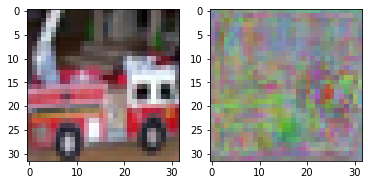

 43%|████▎     | 340/782 [02:12<02:52,  2.56it/s, loss=0.0938, ep=0]

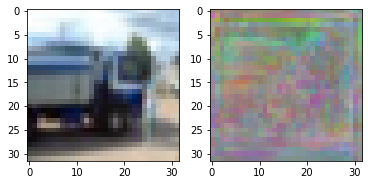

 46%|████▌     | 360/782 [02:20<02:45,  2.55it/s, loss=0.0893, ep=0]

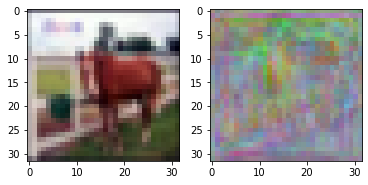

 49%|████▊     | 380/782 [02:28<02:39,  2.52it/s, loss=0.0851, ep=0]

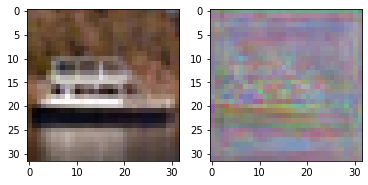

 51%|█████     | 400/782 [02:36<02:27,  2.59it/s, loss=0.0904, ep=0]

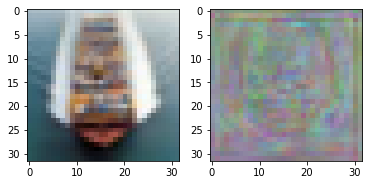

 54%|█████▎    | 420/782 [02:45<02:26,  2.47it/s, loss=0.089, ep=0] 

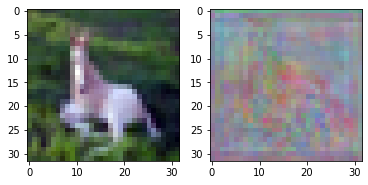

 56%|█████▋    | 440/782 [02:52<02:09,  2.63it/s, loss=0.0915, ep=0]

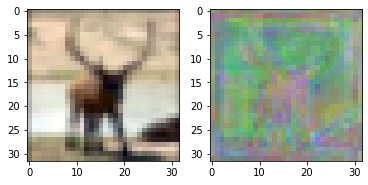

 59%|█████▉    | 460/782 [03:01<02:02,  2.63it/s, loss=0.0876, ep=0]

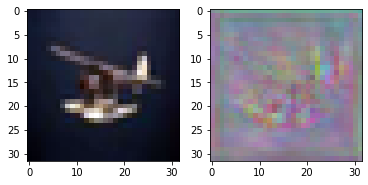

 61%|██████▏   | 480/782 [03:09<02:02,  2.47it/s, loss=0.0922, ep=0]

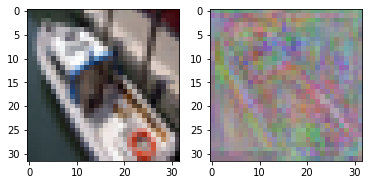

 64%|██████▍   | 500/782 [03:17<01:57,  2.40it/s, loss=0.0878, ep=0]

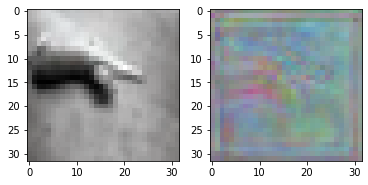

 66%|██████▋   | 520/782 [03:26<01:45,  2.49it/s, loss=0.0884, ep=0]

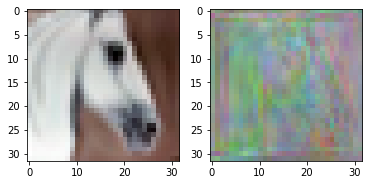

 69%|██████▉   | 540/782 [03:29<00:50,  4.77it/s, loss=0.094, ep=0] 

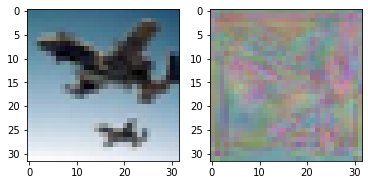

 72%|███████▏  | 560/782 [03:34<01:20,  2.75it/s, loss=0.0906, ep=0]

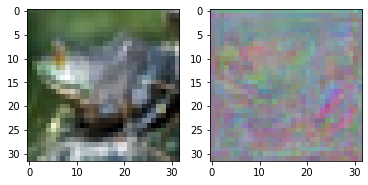

 74%|███████▍  | 580/782 [03:42<01:21,  2.47it/s, loss=0.0897, ep=0]

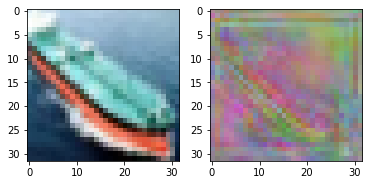

 77%|███████▋  | 600/782 [03:51<01:13,  2.48it/s, loss=0.0894, ep=0]

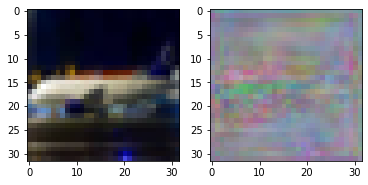

 79%|███████▉  | 620/782 [03:59<01:06,  2.43it/s, loss=0.0856, ep=0]

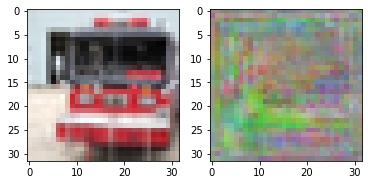

 82%|████████▏ | 640/782 [04:07<00:57,  2.48it/s, loss=0.0902, ep=0]

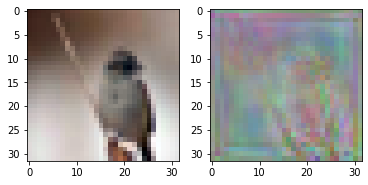

 84%|████████▍ | 660/782 [04:16<00:49,  2.45it/s, loss=0.0812, ep=0]

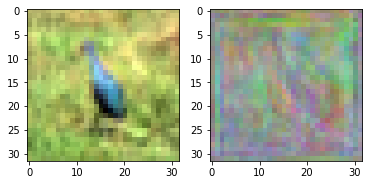

 87%|████████▋ | 680/782 [04:24<00:39,  2.61it/s, loss=0.0904, ep=0]

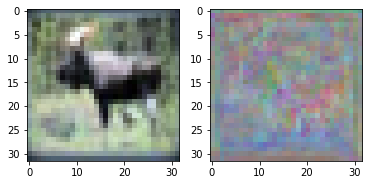

 90%|████████▉ | 700/782 [04:32<00:33,  2.43it/s, loss=0.0913, ep=0]

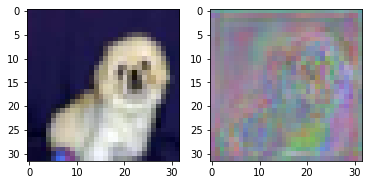

 92%|█████████▏| 720/782 [04:40<00:25,  2.48it/s, loss=0.0893, ep=0]

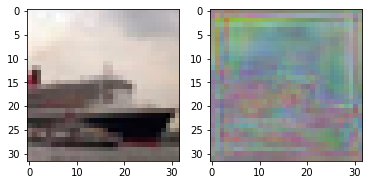

 95%|█████████▍| 740/782 [04:49<00:17,  2.41it/s, loss=0.0821, ep=0]

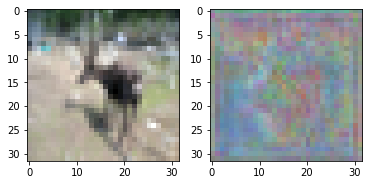

 97%|█████████▋| 760/782 [04:57<00:08,  2.51it/s, loss=0.0895, ep=0]

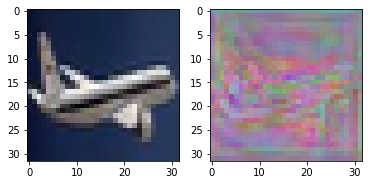

100%|█████████▉| 780/782 [05:06<00:00,  2.13it/s, loss=0.088, ep=0] 

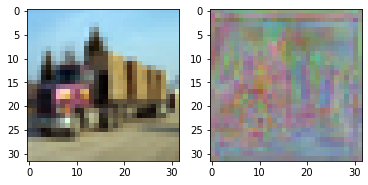

  3%|▎         | 20/782 [00:08<05:03,  2.51it/s, loss=0.0882, ep=1]

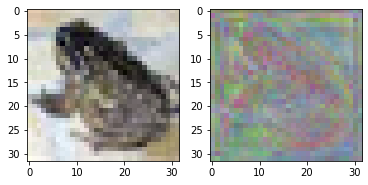

  5%|▌         | 40/782 [00:16<04:45,  2.60it/s, loss=0.0854, ep=1]

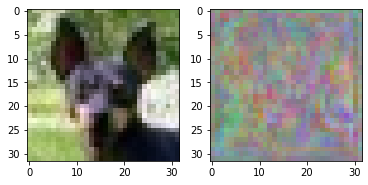

  8%|▊         | 60/782 [00:24<04:35,  2.62it/s, loss=0.0982, ep=1]

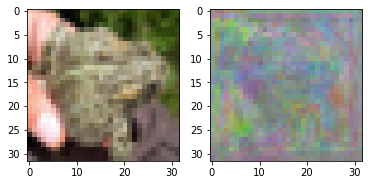

 10%|█         | 80/782 [00:32<04:47,  2.44it/s, loss=0.0866, ep=1]

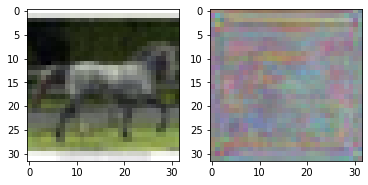

 15%|█▌        | 120/782 [00:41<04:20,  2.55it/s, loss=0.0864, ep=1]

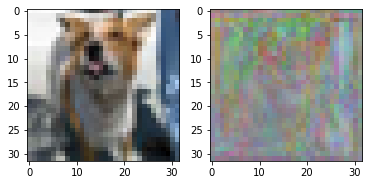

 18%|█▊        | 140/782 [00:49<04:06,  2.61it/s, loss=0.0899, ep=1]

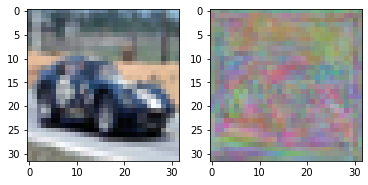

 20%|██        | 160/782 [00:57<03:52,  2.67it/s, loss=0.0924, ep=1]

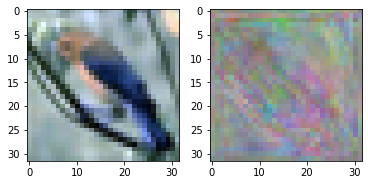

 23%|██▎       | 180/782 [01:05<04:04,  2.47it/s, loss=0.0957, ep=1]

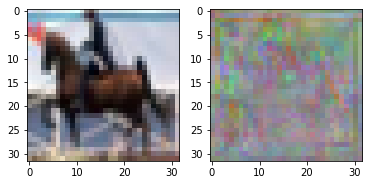

 26%|██▌       | 200/782 [01:13<03:49,  2.54it/s, loss=0.0813, ep=1]

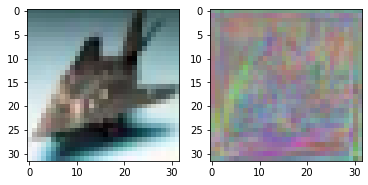

 28%|██▊       | 220/782 [01:22<03:40,  2.55it/s, loss=0.0908, ep=1]

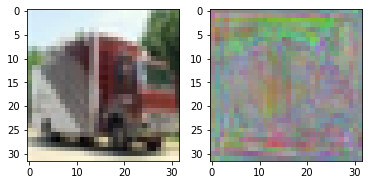

 31%|███       | 240/782 [01:30<03:43,  2.42it/s, loss=0.0891, ep=1]

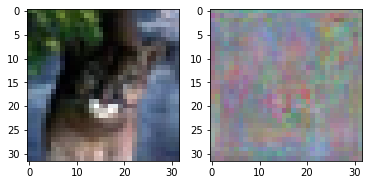

 33%|███▎      | 260/782 [01:38<03:36,  2.41it/s, loss=0.0888, ep=1]

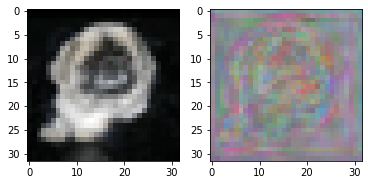

 36%|███▌      | 280/782 [01:46<03:27,  2.42it/s, loss=0.0871, ep=1]

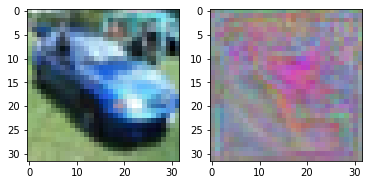

 38%|███▊      | 300/782 [01:54<03:22,  2.39it/s, loss=0.096, ep=1] 

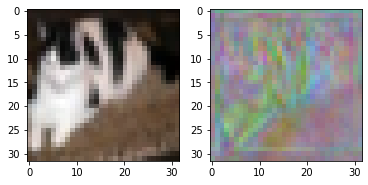

 41%|████      | 320/782 [02:03<02:55,  2.63it/s, loss=0.0869, ep=1]

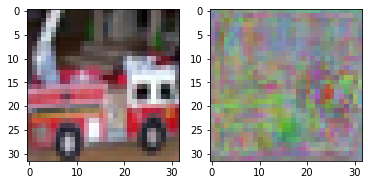

 43%|████▎     | 340/782 [02:11<02:39,  2.77it/s, loss=0.0938, ep=1]

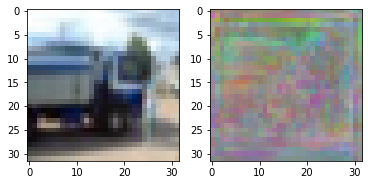

 46%|████▌     | 360/782 [02:19<02:42,  2.60it/s, loss=0.0893, ep=1]

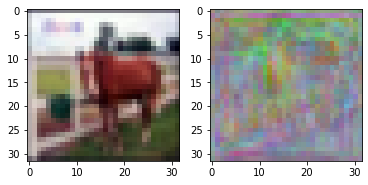

 49%|████▊     | 380/782 [02:27<02:31,  2.65it/s, loss=0.0851, ep=1]

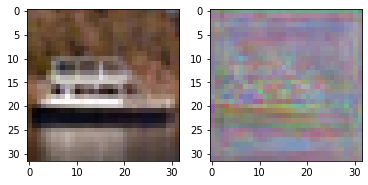

 51%|█████     | 400/782 [02:35<02:39,  2.40it/s, loss=0.0904, ep=1]

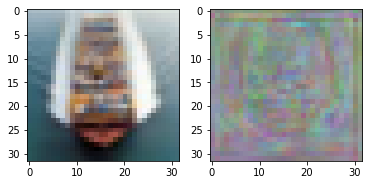

 54%|█████▎    | 420/782 [02:43<02:18,  2.61it/s, loss=0.089, ep=1] 

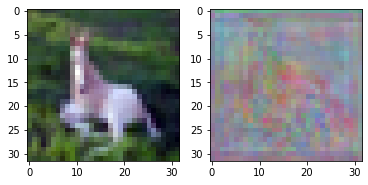

 56%|█████▋    | 440/782 [02:49<00:49,  6.87it/s, loss=0.0915, ep=1]

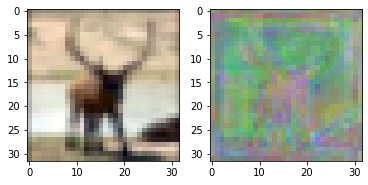

 59%|█████▉    | 460/782 [02:52<00:42,  7.54it/s, loss=0.0876, ep=1]

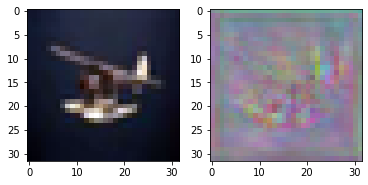

 61%|██████▏   | 480/782 [03:01<01:55,  2.60it/s, loss=0.0922, ep=1]

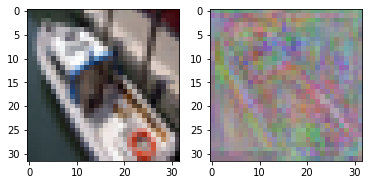

 64%|██████▍   | 500/782 [03:09<01:48,  2.60it/s, loss=0.0878, ep=1]

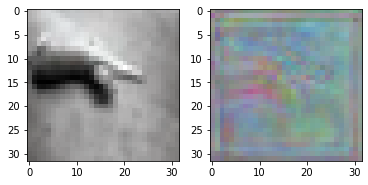

 66%|██████▋   | 520/782 [03:17<01:45,  2.49it/s, loss=0.0884, ep=1]

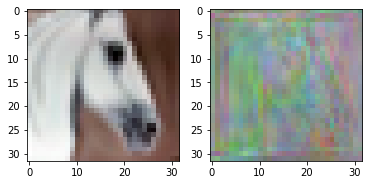

 69%|██████▉   | 540/782 [03:25<01:36,  2.50it/s, loss=0.094, ep=1] 

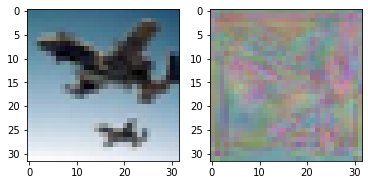

 72%|███████▏  | 560/782 [03:33<01:25,  2.61it/s, loss=0.0906, ep=1]

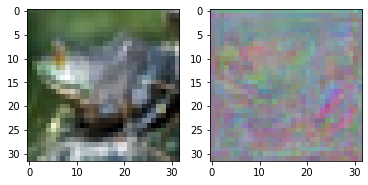

 74%|███████▍  | 580/782 [03:41<01:22,  2.46it/s, loss=0.0897, ep=1]

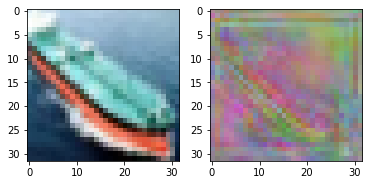

 77%|███████▋  | 600/782 [03:49<01:08,  2.66it/s, loss=0.0894, ep=1]

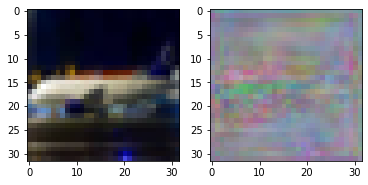

 79%|███████▉  | 620/782 [03:57<01:08,  2.37it/s, loss=0.0856, ep=1]

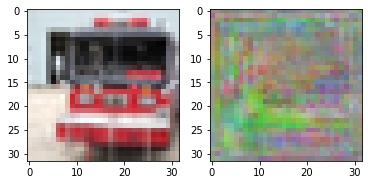

 82%|████████▏ | 640/782 [04:05<00:55,  2.54it/s, loss=0.0902, ep=1]

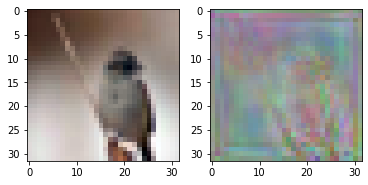

 84%|████████▍ | 660/782 [04:13<00:49,  2.47it/s, loss=0.0812, ep=1]

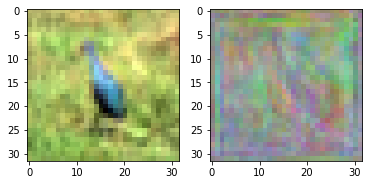

 87%|████████▋ | 680/782 [04:21<00:38,  2.68it/s, loss=0.0904, ep=1]

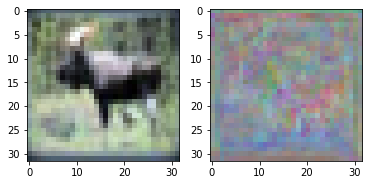

 90%|████████▉ | 700/782 [04:29<00:32,  2.52it/s, loss=0.0913, ep=1]

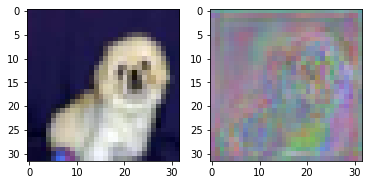

 92%|█████████▏| 720/782 [04:37<00:23,  2.63it/s, loss=0.0893, ep=1]

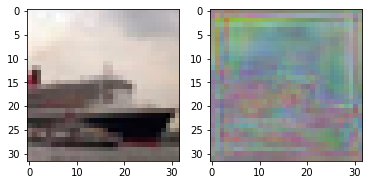

 95%|█████████▍| 740/782 [04:46<00:16,  2.48it/s, loss=0.0821, ep=1]

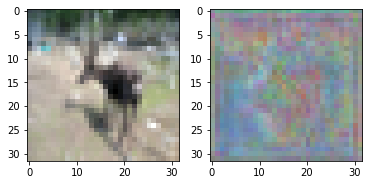

 97%|█████████▋| 760/782 [04:54<00:08,  2.45it/s, loss=0.0895, ep=1]

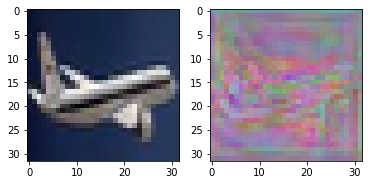

100%|█████████▉| 780/782 [05:01<00:00,  2.62it/s, loss=0.088, ep=1] 

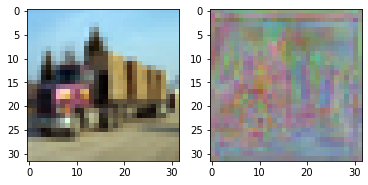

  3%|▎         | 20/782 [00:04<03:15,  3.89it/s, loss=0.0882, ep=2]

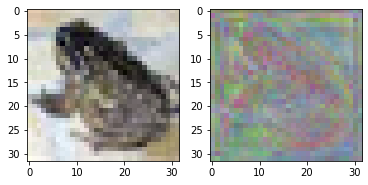

  5%|▌         | 40/782 [00:09<04:37,  2.67it/s, loss=0.0854, ep=2]

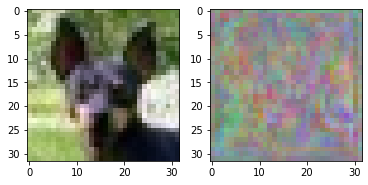

  8%|▊         | 60/782 [00:18<04:53,  2.46it/s, loss=0.0982, ep=2]

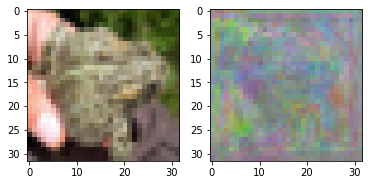

 10%|█         | 80/782 [00:26<04:30,  2.59it/s, loss=0.0866, ep=2]

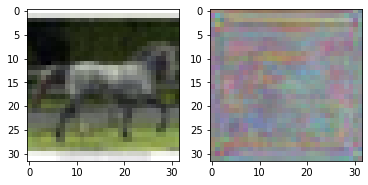

 13%|█▎        | 100/782 [00:34<04:13,  2.69it/s, loss=0.0943, ep=2]

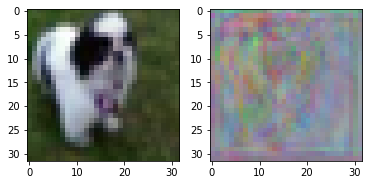

 15%|█▌        | 120/782 [00:42<04:24,  2.50it/s, loss=0.0864, ep=2]

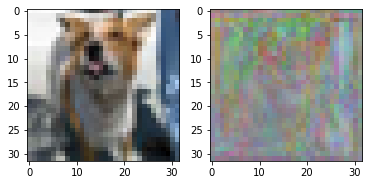

 18%|█▊        | 140/782 [00:50<04:15,  2.52it/s, loss=0.0899, ep=2]

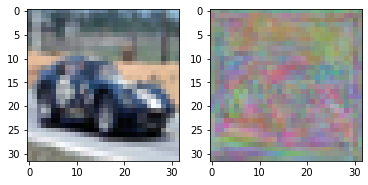

 20%|██        | 160/782 [00:58<04:14,  2.44it/s, loss=0.0924, ep=2]

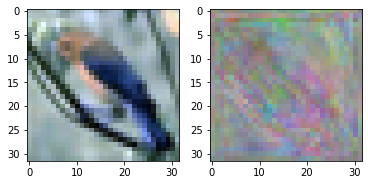

 23%|██▎       | 180/782 [01:06<03:42,  2.71it/s, loss=0.0957, ep=2]

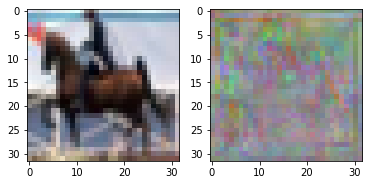

 26%|██▌       | 200/782 [01:14<03:43,  2.60it/s, loss=0.0813, ep=2]

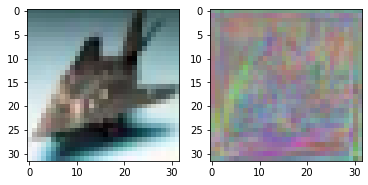

 27%|██▋       | 209/782 [01:18<03:35,  2.66it/s, loss=0.0894, ep=2]


KeyboardInterrupt: 

In [5]:
import tqdm
from torchvision import transforms

def train(model, optimizer, batch, loss_layer):
    optimizer.zero_grad()
    
    out = torch.sigmoid(model(batch))
    
    loss = loss_layer(out, batch)
    optimizer.step()
    loss.backward()
    
    return {'loss': loss.item()}, out

device = torch.device('cuda:2')
model = UNet(3, 3).to(device)

loss_layer = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                             step_size=1,
                                             gamma=0.9)

loader = get_cifar10_train_loader(batch_size=64, n_augments=-1, augment_labels=False)
#norm = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

def norm(inp):
    t = inp.view(3, -1)
    vals_max, _ = t.max(-1)
    vals_max = vals_max.repeat(32, 32, 1).transpose(0, 2)
    
    vals_min, _ = t.min(-1)
    vals_min = vals_min.repeat(32, 32, 1).transpose(0, 2)
    return torch.div(inp - vals_min, vals_max - vals_min)

for epoch in range(10):
    with tqdm.tqdm(total=len(loader)) as steps:
        for i, (data, lbls) in enumerate(loader):
            data = torch.stack([norm(val) for val in data], dim=0)
            data = data.to(device)
            
            message, out = train(model, optimizer, data, loss_layer)
            
            message['ep'] = epoch
            steps.set_postfix(message)
            steps.update()
            
            if i % 20 == 19:
                inp = data.detach().cpu()
                ot = out.detach().cpu()
                draw_rgb([inp[4], ot[4]])

        scheduler.step()


In [16]:
def percentile(t, q):
    """
    Return the ``q``-th percentile of the flattened input tensor's data.
    
    CAUTION:
     * Needs PyTorch >= 1.1.0, as ``torch.kthvalue()`` is used.
     * Values are not interpolated, which corresponds to
       ``numpy.percentile(..., interpolation="nearest")``.
       
    :param t: Input tensor.
    :param q: Percentile to compute, which must be between 0 and 100 inclusive.
    :return: Resulting value (scalar).
    """
    # Note that ``kthvalue()`` works one-based, i.e. the first sorted value
    # indeed corresponds to k=1, not k=0! Use float(q) instead of q directly,
    # so that ``round()`` returns an integer, even if q is a np.float32.
    k = 1 + round(.01 * float(q) * (t.size(-1) - 1))
    result = t.kthvalue(k, dim=-1).values
    return result

In [17]:
t = torch.randint(0, 90, (10, 10))
t

tensor([[26, 28,  1, 32, 70,  4, 51,  3, 19, 48],
        [38, 51,  1, 19, 64, 82, 38, 89, 14, 44],
        [ 9, 84, 59, 72, 16, 66, 16,  3, 63, 74],
        [60, 57, 10, 70,  8,  0, 50,  9, 58, 49],
        [63, 22, 46, 27, 80, 77, 89, 25, 29, 67],
        [36,  9, 88, 66, 72, 37, 18, 38, 63, 48],
        [21, 82, 88, 39, 39, 50, 41, 56, 48, 66],
        [10, 49, 34, 71, 62, 46, 35, 26, 88, 29],
        [62, 83, 62, 57, 74, 69, 16, 39, 40, 75],
        [ 1, 77, 82, 86, 24, 17, 32, 47, 74, 11]])

In [19]:
percentile(t, 95)

tensor([70, 89, 84, 70, 89, 88, 88, 88, 83, 86])

In [13]:
t.kthvalue(1, dim=-1).values

tensor([ 9, 16,  4, 25,  8,  1,  4,  5, 12, 11])

In [14]:
q = 10
k = 1 + round(.01 * float(q) * (t.size(-1) - 1))
k

2

In [15]:
t.kthvalue(k, dim=-1).values

tensor([35, 17, 15, 27, 14, 23,  5, 32, 17, 12])

In [20]:
t = torch.randint(0, 10, (10, 5))
t

tensor([[6, 1, 1, 8, 5],
        [5, 6, 9, 1, 5],
        [2, 2, 4, 7, 3],
        [0, 7, 2, 8, 3],
        [8, 4, 8, 4, 4],
        [2, 8, 4, 0, 3],
        [9, 0, 2, 9, 1],
        [5, 9, 5, 9, 7],
        [2, 0, 7, 1, 9],
        [2, 6, 5, 6, 6]])

In [22]:
t.sort(dim=-1).values

tensor([[1, 1, 5, 6, 8],
        [1, 5, 5, 6, 9],
        [2, 2, 3, 4, 7],
        [0, 2, 3, 7, 8],
        [4, 4, 4, 8, 8],
        [0, 2, 3, 4, 8],
        [0, 1, 2, 9, 9],
        [5, 5, 7, 9, 9],
        [0, 1, 2, 7, 9],
        [2, 5, 6, 6, 6]])

In [24]:
mask = torch.zeros(10)
mask[:5] = 1
mask

tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

In [26]:
mask = mask.expand(3, mask.size(0))

In [27]:
mask

tensor([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]])

In [28]:
1 - mask

tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])

In [5]:
[i for i in range(0, 100, int(100/6))]

[0, 16, 32, 48, 64, 80, 96]

In [4]:
lbls = torch.Tensor([0,0,0,1,1,2,2,2,2])

num_lbls = lbls.max().int().item() + 1
m = lbls.expand(num_lbls, lbls.size(0))
k = torch.arange(num_lbls).expand(lbls.size(0), num_lbls).transpose(0, 1).to(lbls.device)
m1 = (m == k).int().sum(-1)

m1

tensor([3, 2, 4])

In [7]:
n_augs = 5
elems_embs = torch.randn(3, n_augs, 32)

elems_embs = elems_embs.view(-1, elems_embs.size(-1))



In [16]:
lbls = torch.arange(3).expand(n_augs, 3).transpose(0, 1).contiguous().view(-1)
lbls

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [17]:
ll = lbls.expand(lbls.size(0), lbls.size(0))
m0 = (ll == ll.transpose(0, 1)).int()
m0

tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]], dtype=torch.int32)

In [20]:
l = [0, 4, 3, 5, 6, 3]
n = np.array(l)

In [21]:
n.mean()

3.5

In [22]:
n.std()

1.8929694486000912

In [24]:
n.var().pow(0.5)

AttributeError: 'numpy.float64' object has no attribute 'pow'